In [1055]:
import numpy as np
import pandas as pd

from utils.plots import plot_water_over_time


In [1056]:
ESCALE = 10e5

In [1057]:
df_cav = pd.read_csv('./data/sume_cotas.csv')
df_areas = pd.read_csv('./data/areas.csv')
df_aesa = pd.read_csv('./data/sume_aesa.csv')

In [1058]:
df_aesa['year'] = df_aesa['Data da Medição'].apply(lambda x: x.split('/')[-1])
df_aesa['month'] = df_aesa['Data da Medição'].apply(lambda x: x.split('/')[-2])
df_aesa['Volume Útil (hm³)'] = df_aesa['Volume Útil (hm³)'].apply(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)
df_aesa['volume_m2'] = df_aesa['Volume Útil (hm³)'].apply(lambda x: x * 1000000 / ESCALE)

In [1059]:
df_aesa.describe()

,Volume Útil (hm³),volume_m2
count,2442.00000,2442.00000
mean,5.59932,5.59932
std,4.58442,4.58442
min,0.39000,0.39000
25%,2.42500,2.42500
50%,3.79000,3.79000
75%,7.21250,7.21250
max,18.80000,18.80000


### Preprocessing

#### Select points by date

In [1060]:
def select_points_by_date(df, dates):
    df['date'] = df['month'].astype(str).str.zfill(2) + '/' + df['year'].astype(str)
    df = df.loc[df['date'].isin(dates)]
    return df

In [1061]:
# df_areas = select_points_by_date(df_areas, df_aesa['Data da Medição'].unique())

In [1062]:
# df_areas['date']

### Estimate

In [1063]:
def estimar_volumes_para_multiplas_colunas(df_areas: pd.DataFrame, df_cav: pd.DataFrame):

    # 2. Ordena e remove duplicatas na curva CAV
    df_cav = df_cav.sort_values("area").drop_duplicates(subset=["area"])

    # 3. Define limites da curva para evitar extrapolação
    min_area = df_cav["area"].min()
    max_area = df_cav["area"].max()

    # 4. Para cada coluna de área, gerar a coluna correspondente de volume
    colunas_area = df_areas.columns
    for coluna in colunas_area:
        if "m2" in coluna:
            # Garante que as áreas estejam dentro dos limites da CAV
            areas = df_areas[coluna].clip(lower=min_area, upper=max_area)

            # Interpola e converte para milhões de m³
            volumes = np.interp(areas, df_cav["area"], df_cav["volume"])
            df_areas[f"volume_{coluna}"] = volumes / ESCALE  # volume em 10⁶ m³

    return df_areas


In [1064]:
df_resultado = estimar_volumes_para_multiplas_colunas(df_areas=df_areas, df_cav=df_cav)
df_resultado.to_csv("./data/volumes.csv", index=False)

In [1065]:
df_aesa['volume_m2'].describe()

count    2442.00000
mean        5.59932
std         4.58442
min         0.39000
25%         2.42500
50%         3.79000
75%         7.21250
max        18.80000
Name: volume_m2, dtype: float64

In [1066]:
df_resultado['volume_m2_area_fmask_deepwatermap'].describe()

count    477.000000
mean      12.482677
std        7.669183
min        0.255969
25%        6.035746
50%       11.033066
75%       18.337391
max       36.976158
Name: volume_m2_area_fmask_deepwatermap, dtype: float64

In [1067]:
df_resultado.head()

,m2_area_fmask_deepwatermap,km2_area_fmask_deepwatermap,m2_area_deepwatermap,km2_area_deepwatermap,km2_area_ndwi,m2_area_fmask_ndwi,km2_area_fmask_ndwi,m2_area_mndwi,km2_area_mndwi,m2_area_fmask_mndwi,...,volume_m2_area_deepwatermap,volume_km2_area_deepwatermap,volume_km2_area_ndwi,volume_m2_area_fmask_ndwi,volume_km2_area_fmask_ndwi,volume_m2_area_mndwi,volume_km2_area_mndwi,volume_m2_area_fmask_mndwi,volume_km2_area_fmask_mndwi,volume_m2_area_ndwi
0,4.735766e+06,4.735766,7.454560e+06,7.454560,0.087013,1.014202e+06,1.014202,2.543595e+06,2.543595,3.270280e+06,...,36.388686,0.000002,2.610397e-08,1.451281,3.042605e-07,6.221542,7.630785e-07,9.513460,9.810841e-07,0.071821
1,4.675754e+06,4.675754,9.651077e+06,9.651077,0.000000,3.539655e+05,0.353965,2.446290e+07,24.462902,8.834444e+05,...,44.864100,0.000003,0.000000e+00,0.382107,1.061896e-07,44.864100,7.338870e-06,1.197408,2.650333e-07,0.000000
2,3.807888e+06,3.807888,8.685063e+06,8.685063,0.000000,1.689022e+05,0.168902,1.319741e+07,13.197410,9.224372e+05,...,44.864100,0.000003,0.000000e+00,0.172424,5.067067e-08,44.864100,3.959223e-06,1.270682,2.767312e-07,0.000000
3,1.168421e+06,1.168421,6.314420e+06,6.314420,0.135398,9.775832e+06,9.775832,8.700529e+05,0.870053,3.269877e+07,...,28.563683,0.000002,4.061931e-08,44.864100,2.932750e-06,1.172244,2.610159e-07,44.864100,9.809630e-06,0.130391
4,3.709049e+06,3.709049,3.544877e+06,3.544877,0.270007,7.150654e+06,7.150654,8.182593e+05,0.818259,2.564726e+07,...,11.151799,0.000001,8.100212e-08,34.488342,2.145196e-06,1.074916,2.454778e-07,44.864100,7.694178e-06,0.290487


In [1068]:
df_resultado.describe()

,m2_area_fmask_deepwatermap,km2_area_fmask_deepwatermap,m2_area_deepwatermap,km2_area_deepwatermap,km2_area_ndwi,m2_area_fmask_ndwi,km2_area_fmask_ndwi,m2_area_mndwi,km2_area_mndwi,m2_area_fmask_mndwi,...,volume_m2_area_deepwatermap,volume_km2_area_deepwatermap,volume_km2_area_ndwi,volume_m2_area_fmask_ndwi,volume_km2_area_fmask_ndwi,volume_m2_area_mndwi,volume_km2_area_mndwi,volume_m2_area_fmask_mndwi,volume_km2_area_fmask_mndwi,volume_m2_area_ndwi
count,4.770000e+02,477.000000,4.800000e+02,480.000000,480.000000,4.770000e+02,477.000000,4.800000e+02,480.000000,4.770000e+02,...,480.000000,4.800000e+02,4.800000e+02,477.000000,4.770000e+02,480.000000,4.800000e+02,477.000000,4.770000e+02,480.000000
mean,3.617533e+06,3.617533,7.258739e+06,7.258739,0.068048,4.797132e+06,4.797132,1.112518e+07,11.125184,1.608707e+07,...,32.572174,2.177622e-06,2.041454e-08,20.516346,1.439140e-06,24.066922,3.337555e-06,32.307919,4.826122e-06,0.083541
std,1.416000e+06,1.416000,2.721252e+06,2.721252,0.197579,3.632094e+06,3.632094,1.151780e+07,11.517796,1.200026e+07,...,14.782927,8.163756e-07,5.927358e-08,18.412239,1.089628e-06,19.519330,3.455339e-06,17.853211,3.600079e-06,0.290754
min,2.383748e+05,0.238375,0.000000e+00,0.000000,0.000000,1.842749e+04,0.018427,1.679844e+05,0.167984,2.491211e+05,...,0.000000,0.000000e+00,0.000000e+00,0.011419,5.528247e-09,0.171273,5.039532e-08,0.267696,7.473632e-08,0.000000
25%,2.499438e+06,2.499438,5.119023e+06,5.119023,0.000000,1.233164e+06,1.233164,1.657271e+06,1.657271,3.614914e+06,...,20.713728,1.535707e-06,0.000000e+00,2.037892,3.699491e-07,3.141552,4.971812e-07,11.593612,1.084474e-06,0.000000
50%,3.526056e+06,3.526056,8.484331e+06,8.484331,0.000000,4.363077e+06,4.363077,5.607144e+06,5.607144,1.469854e+07,...,43.721230,2.545299e-06,0.000000e+00,16.111323,1.308923e-06,23.826045,1.682143e-06,44.864100,4.409561e-06,0.000000
75%,4.735766e+06,4.735766,9.775857e+06,9.775857,0.006602,9.034791e+06,9.034791,2.038741e+07,20.387409,2.947398e+07,...,44.864100,2.932757e-06,1.980709e-09,44.864100,2.710437e-06,44.864100,6.116223e-06,44.864100,8.842193e-06,0.002585
max,7.555369e+06,7.555369,9.776029e+06,9.776029,1.604867,9.776029e+06,9.776029,3.269896e+07,32.698962,3.269896e+07,...,44.864100,2.932809e-06,4.814600e-07,44.864100,2.932809e-06,44.864100,9.809689e-06,44.864100,9.809689e-06,3.010018


In [1069]:
deepwater_map_df = df_resultado[['volume_m2_area_fmask_deepwatermap', 'volume_m2_area_deepwatermap', 'year', 'month']]
deepwater_map_df.rename(columns={'volume_m2_area_fmask_deepwatermap': 'fmask_volume_m2', 'volume_m2_area_deepwatermap': 'volume_m2'}, inplace=True)


C:\Users\weverton.vitor\AppData\Local\Temp\ipykernel_38272\1224121787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deepwater_map_df.rename(columns={'volume_m2_area_fmask_deepwatermap': 'fmask_volume_m2', 'volume_m2_area_deepwatermap': 'volume_m2'}, inplace=True)


## Plot

In [1070]:
columns = [column for column in list(df_resultado.columns) if column.startswith("volume_m2")]

In [1071]:
columns

['volume_m2_area_fmask_deepwatermap',
 'volume_m2_area_deepwatermap',
 'volume_m2_area_fmask_ndwi',
 'volume_m2_area_mndwi',
 'volume_m2_area_fmask_mndwi',
 'volume_m2_area_ndwi']

In [1072]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

def plot_series_ano_mes(series_dict, data_inicio, data_fim, titulo=None):
    """
    Plota séries temporais com colunas separadas de 'ano' e 'mês' e diferentes comprimentos.

    Parâmetros:
        series_dict (dict): {'nome_série': DataFrame com colunas ['ano', 'mes', 'valor']}.
        data_inicio (str): Data inicial no formato "mm/yyyy".
        data_fim (str): Data final no formato "mm/yyyy".
        titulo (str): Título do gráfico (opcional).
    """
    # Converte as datas para datetime
    data_inicio = pd.to_datetime(f"01/{data_inicio}", format="%d/%m/%Y")
    data_fim = pd.to_datetime(f"01/{data_fim}", format="%d/%m/%Y") + pd.offsets.MonthEnd(0)

    # Inicia figura
    plt.figure(figsize=(12, 5))

    for nome, df in series_dict.items():
        # Cria coluna de datas com ano e mês
        df = df.copy()
        df['data'] = pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))
        df = df.set_index('data')

        # Filtra pelo intervalo
        df_plot = df[(df.index >= data_inicio) & (df.index <= data_fim)]

        # Plota
        plt.plot(df_plot.index, df_plot['volume_m2'], label=nome)

    # Formatação
    plt.xlabel("Data")
    plt.ylabel("Valor")
    plt.title(titulo or "Séries Temporais")
    plt.legend()
    plt.grid(True)

    # Eixo X no formato mm/yyyy
    plt.gca().xaxis.set_major_formatter(DateFormatter("%m/%Y"))

    plt.tight_layout()
    plt.show()


In [1073]:
def media_mensal_por_ano(df):
    """
    Calcula a média de valores para cada mês de cada ano.

    Parâmetros:
        df (pd.DataFrame): DataFrame com colunas ['ano', 'mes', 'valor'].

    Retorna:
        pd.DataFrame: Agrupado com média por ano e mês.
    """
    return (
        df.groupby(['year', 'month'], as_index=False)
          .agg({'volume_m2': 'mean'})
          .sort_values(['year', 'month'])
    )


In [1074]:
deepwater_mean_df = media_mensal_por_ano(deepwater_map_df)
aesa_mean_df = media_mensal_por_ano(df_aesa)

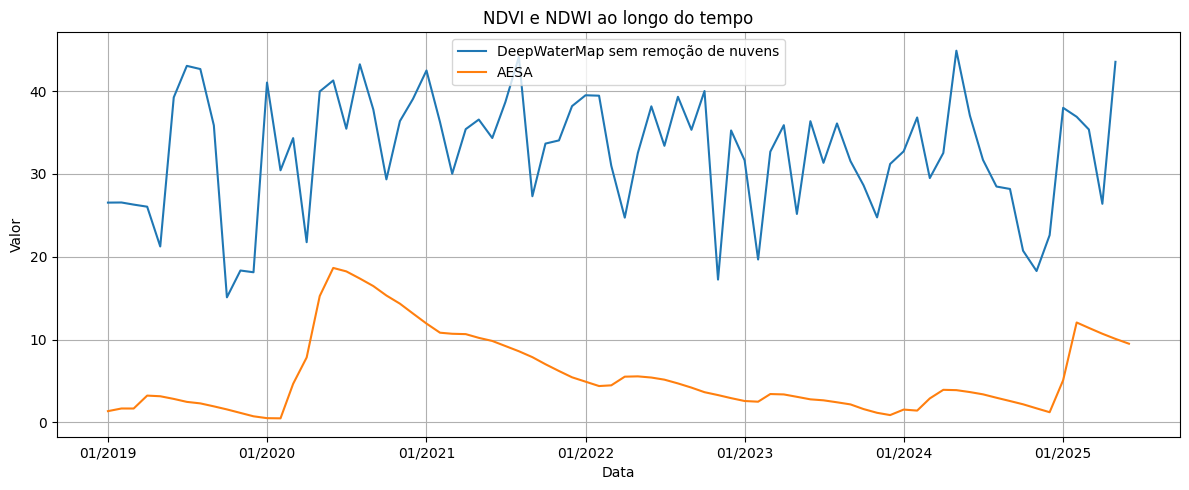

In [1075]:

plot_series_ano_mes(
    {
        "DeepWaterMap sem remoção de nuvens": deepwater_mean_df,
        "AESA": aesa_mean_df
    },
    data_inicio="01/2019",
    data_fim="06/2025",
    titulo="NDVI e NDWI ao longo do tempo"
)


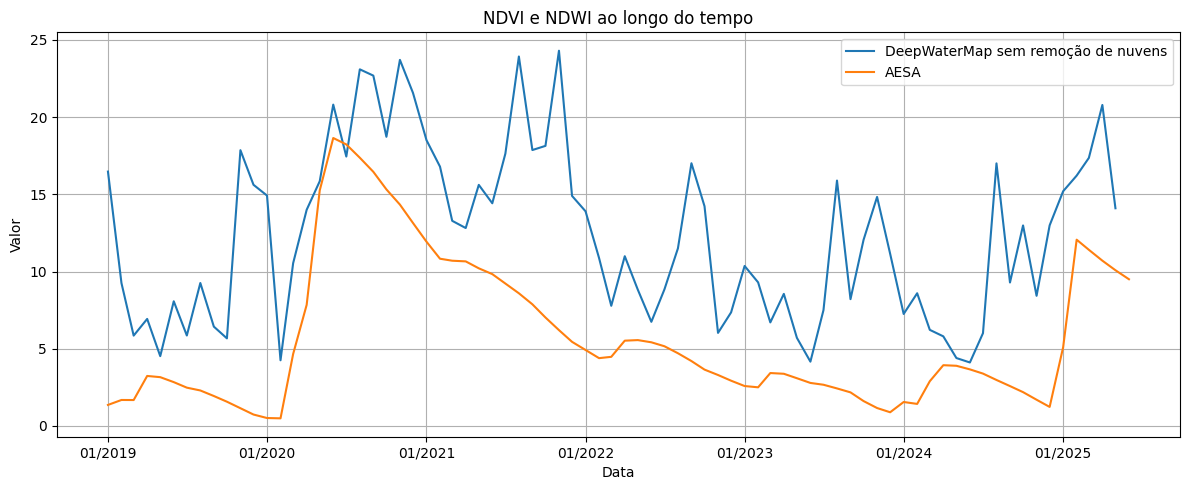

In [1076]:
deepwater_mean_df = media_mensal_por_ano(deepwater_map_df.drop(columns=['volume_m2']).rename(columns={'fmask_volume_m2': 'volume_m2'}))
plot_series_ano_mes(
    {
        "DeepWaterMap sem remoção de nuvens": deepwater_mean_df,
        "AESA": aesa_mean_df
    },
    data_inicio="01/2019",
    data_fim="06/2025",
    titulo="NDVI e NDWI ao longo do tempo"
)


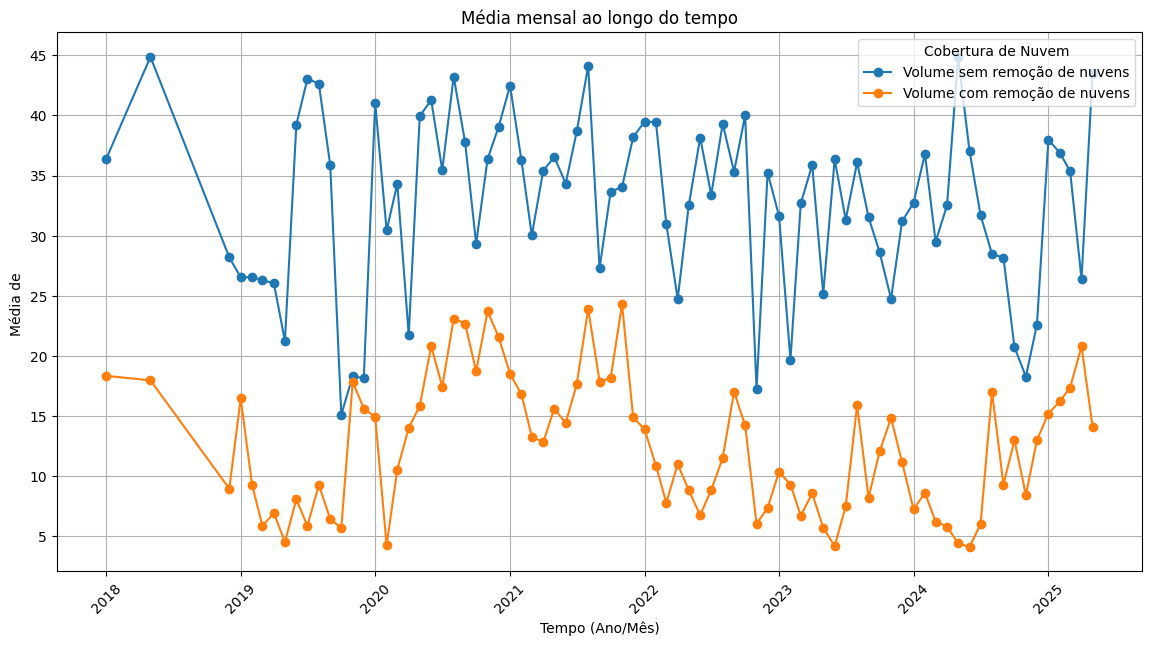

In [1077]:
plot_water_over_time(
    df_resultado,
    y_variables=[
        "volume_m2_area_deepwatermap",
        "volume_m2_area_fmask_deepwatermap",
    ],
    labels=["Volume sem remoção de nuvens", "Volume com remoção de nuvens", "Volume Aesa"],
)



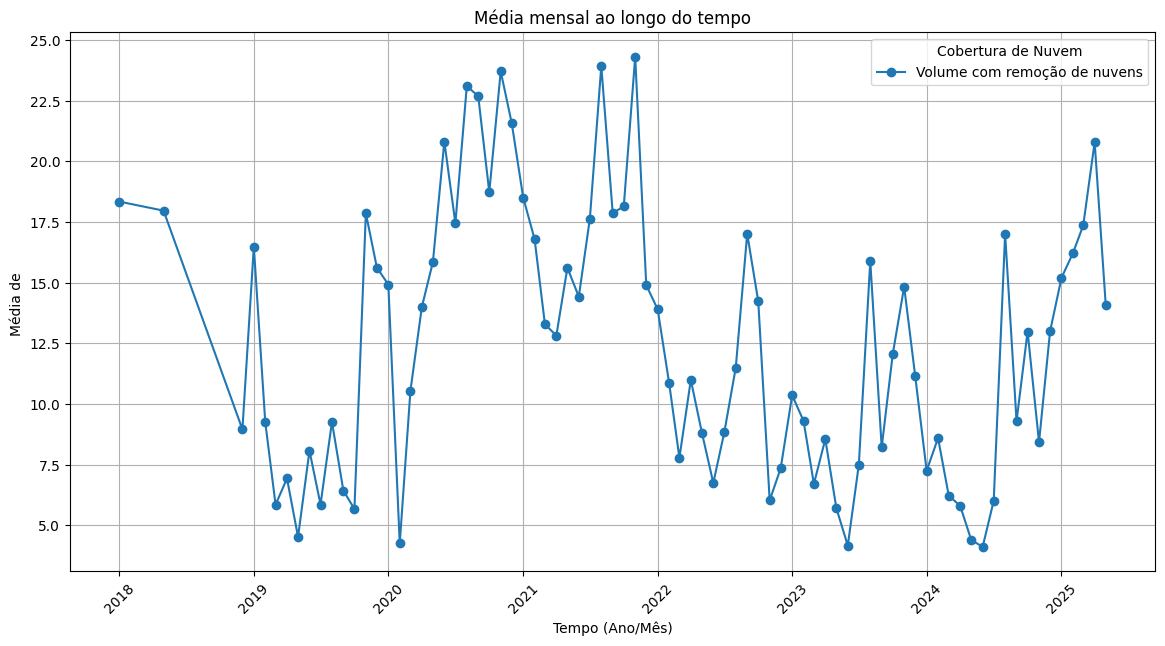

In [1078]:
plot_water_over_time(
    df_resultado,
    y_variables=[
        "volume_m2_area_fmask_deepwatermap",
    #    "volume_aesa"
    ],
    labels=["Volume com remoção de nuvens", "Volume Aesa"],
)


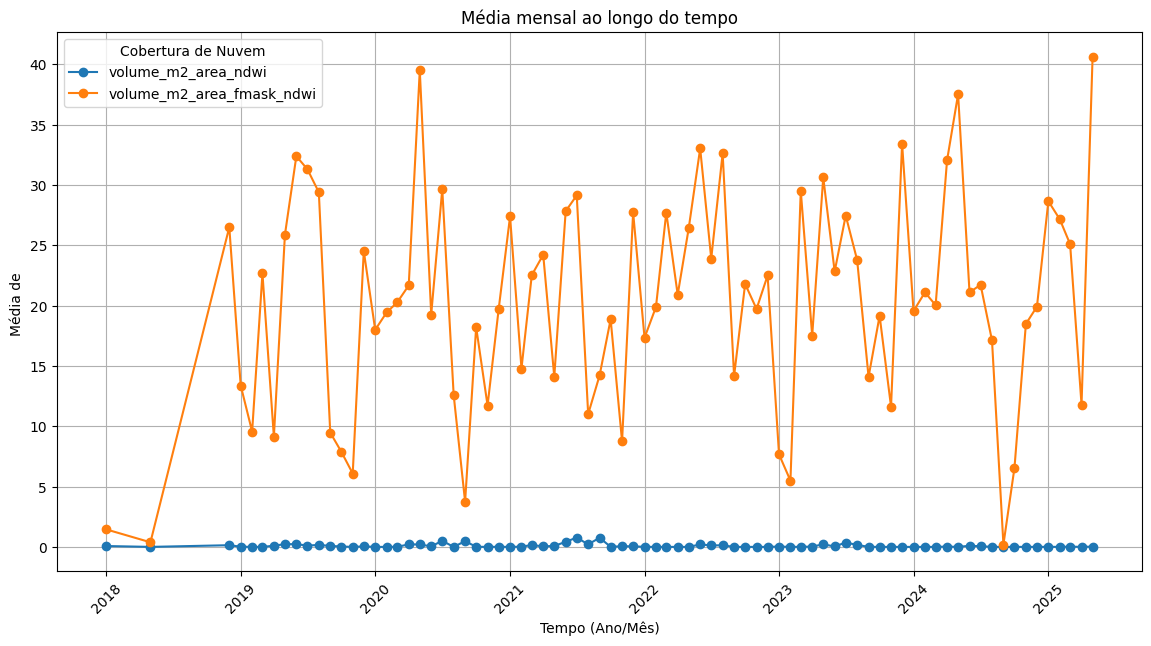

In [1079]:
plot_water_over_time(
    df_resultado,
    y_variables=["volume_m2_area_ndwi", "volume_m2_area_fmask_ndwi"],
    labels=["volume_m2_area_ndwi", "volume_m2_area_fmask_ndwi"],
)


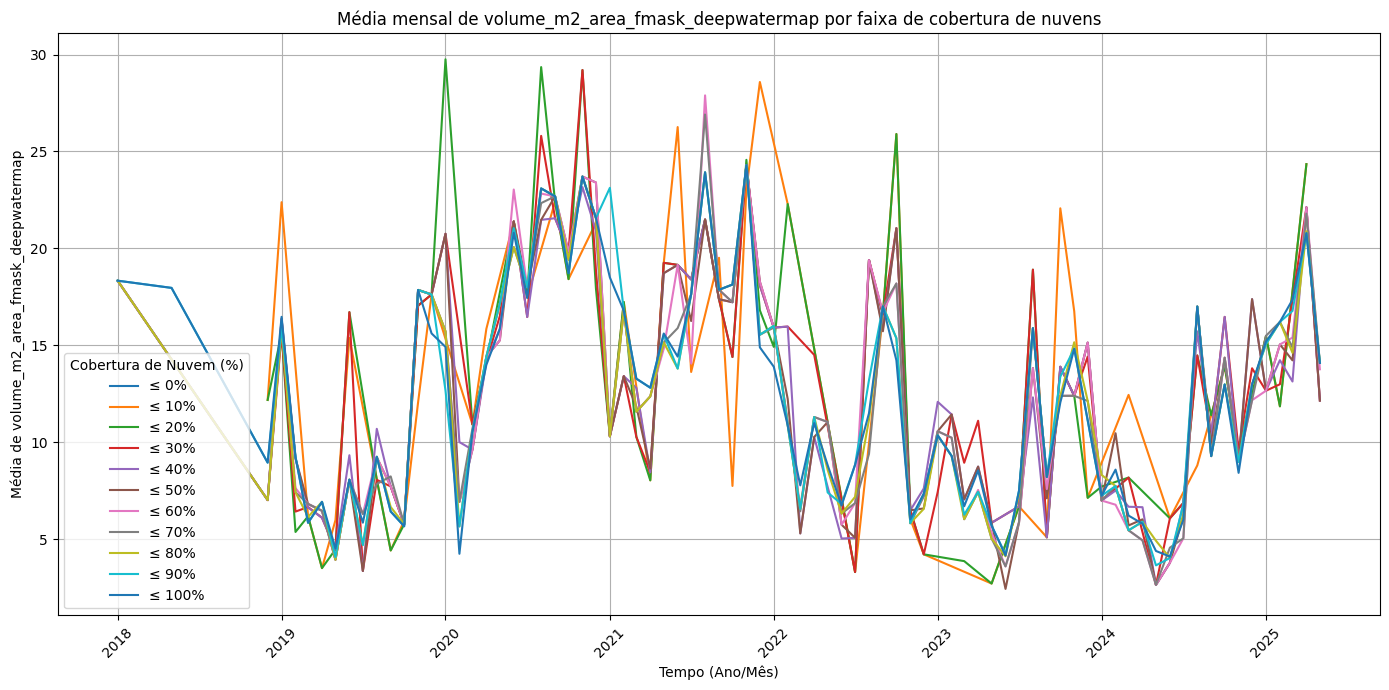

In [1080]:
from utils.plots import plot_water_x_cloud_percent_over_time


plot_water_x_cloud_percent_over_time(
    df_resultado.loc[df_resultado["CLOUDY_PIXEL_PERCENTAGE"] <= 100],
    y_variable="volume_m2_area_fmask_deepwatermap",
)


### Mean Filter

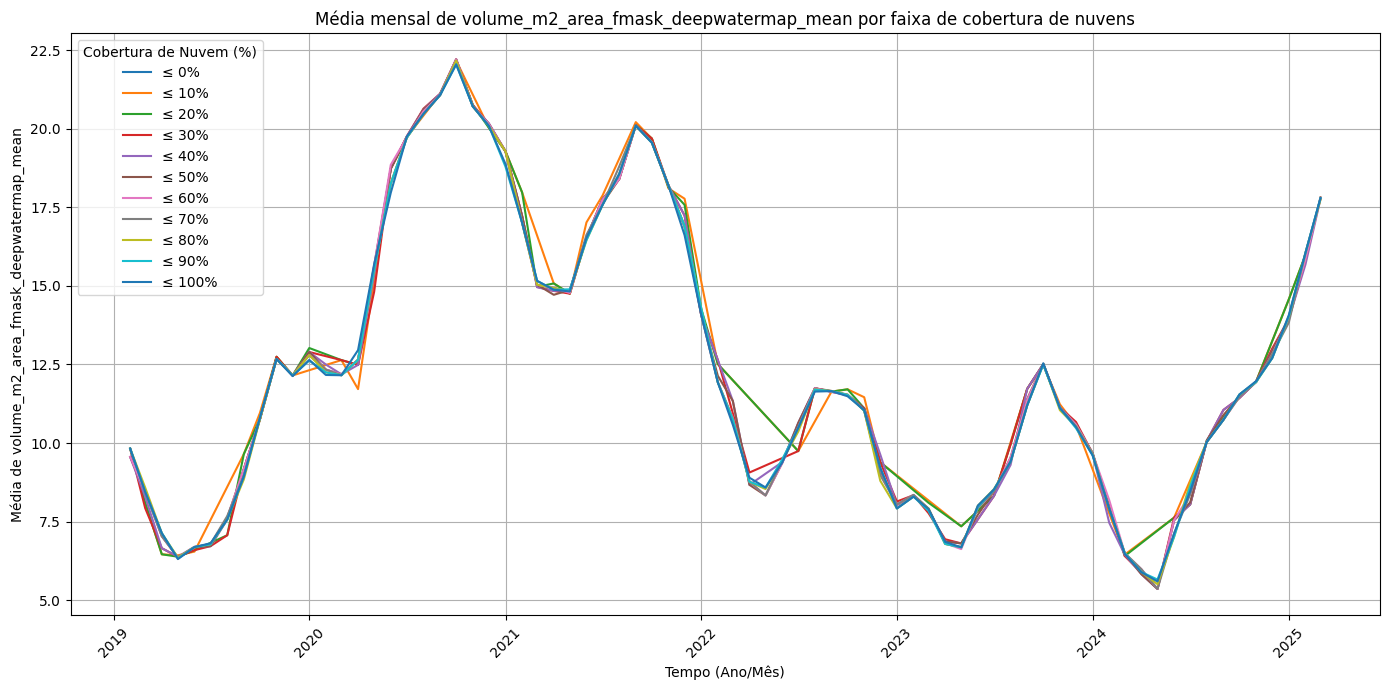

In [1081]:
df_resultado["volume_m2_area_fmask_deepwatermap_mean"] = (
    df_resultado["volume_m2_area_fmask_deepwatermap"].rolling(window=30, center=True).mean()
)
plot_water_x_cloud_percent_over_time(
    df_resultado.loc[df_resultado["CLOUDY_PIXEL_PERCENTAGE"] <= 100],
    y_variable="volume_m2_area_fmask_deepwatermap_mean",
)


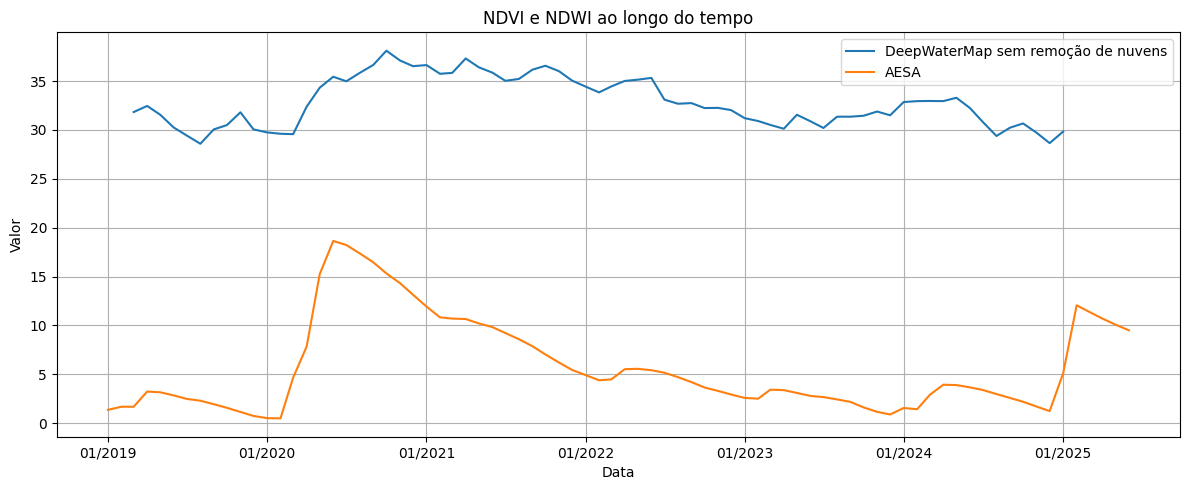

In [1082]:
# deepwater_mean_df = media_mensal_por_ano(deepwater_map_df.drop(columns=['volume_m2']).rename(columns={'fmask_volume_m2': 'volume_m2'}))
deepwater_mean_df = media_mensal_por_ano(deepwater_map_df)

deepwater_mean_df["volume_m2"] = (
    deepwater_mean_df["volume_m2"].rolling(window=10, center=True).mean()
)

plot_series_ano_mes(
    {
        "DeepWaterMap sem remoção de nuvens": deepwater_mean_df,
        "AESA": aesa_mean_df
    },
    data_inicio="01/2019",
    data_fim="06/2025",
    titulo="NDVI e NDWI ao longo do tempo"
)


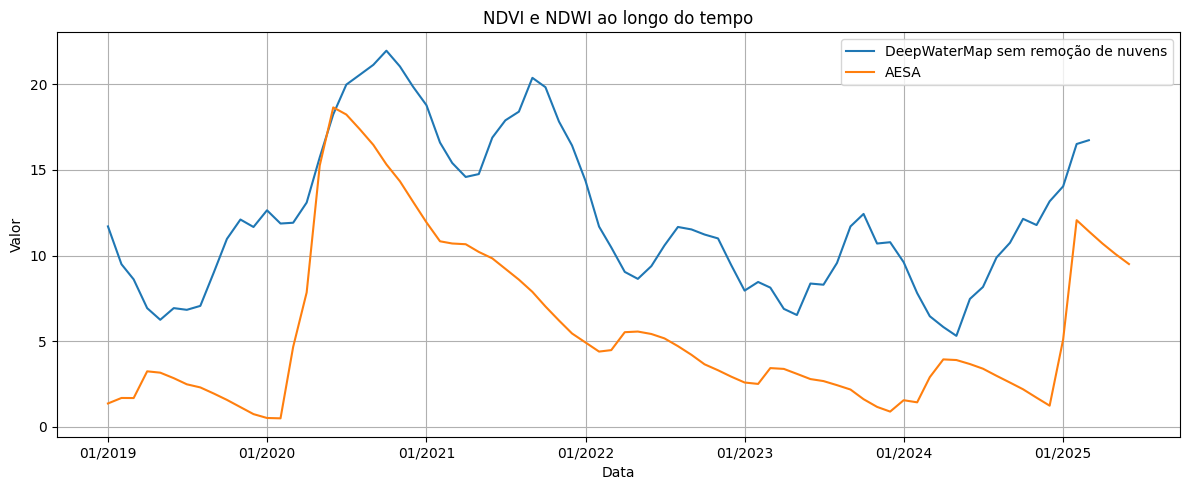

In [1083]:
deepwater_mean_df = media_mensal_por_ano(deepwater_map_df.drop(columns=['volume_m2']).rename(columns={'fmask_volume_m2': 'volume_m2'}))

deepwater_mean_df["volume_m2"] = (
    deepwater_mean_df["volume_m2"].rolling(window=5, center=True).mean()
)

plot_series_ano_mes(
    {
        "DeepWaterMap sem remoção de nuvens": deepwater_mean_df,
        "AESA": aesa_mean_df
    },
    data_inicio="01/2019",
    data_fim="06/2025",
    titulo="NDVI e NDWI ao longo do tempo"
)


### SavGol filter

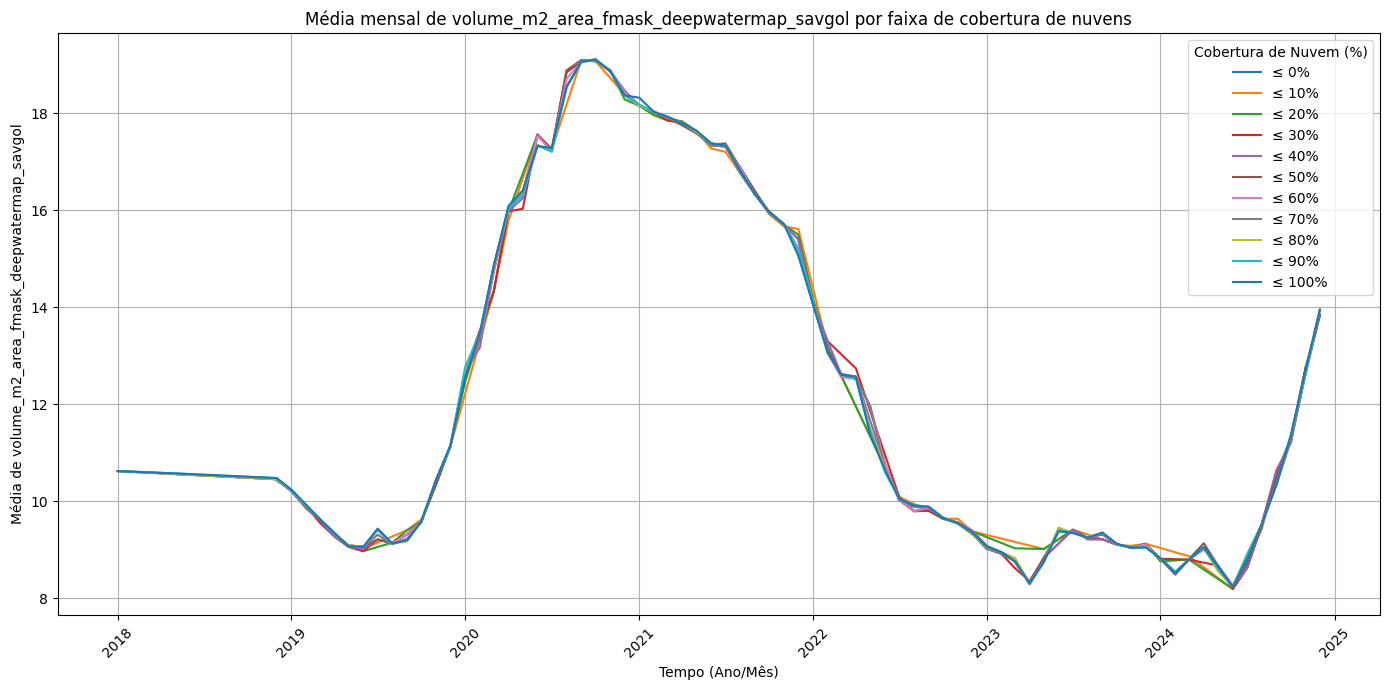

In [1084]:
from scipy.signal import savgol_filter

df_resultado["volume_m2_area_fmask_deepwatermap_savgol"] = savgol_filter(
    df_resultado["volume_m2_area_fmask_deepwatermap"], window_length=70, polyorder=1
)

plot_water_x_cloud_percent_over_time(
    df_resultado.loc[df_resultado["CLOUDY_PIXEL_PERCENTAGE"] <= 100],
    y_variable="volume_m2_area_fmask_deepwatermap_savgol",
)


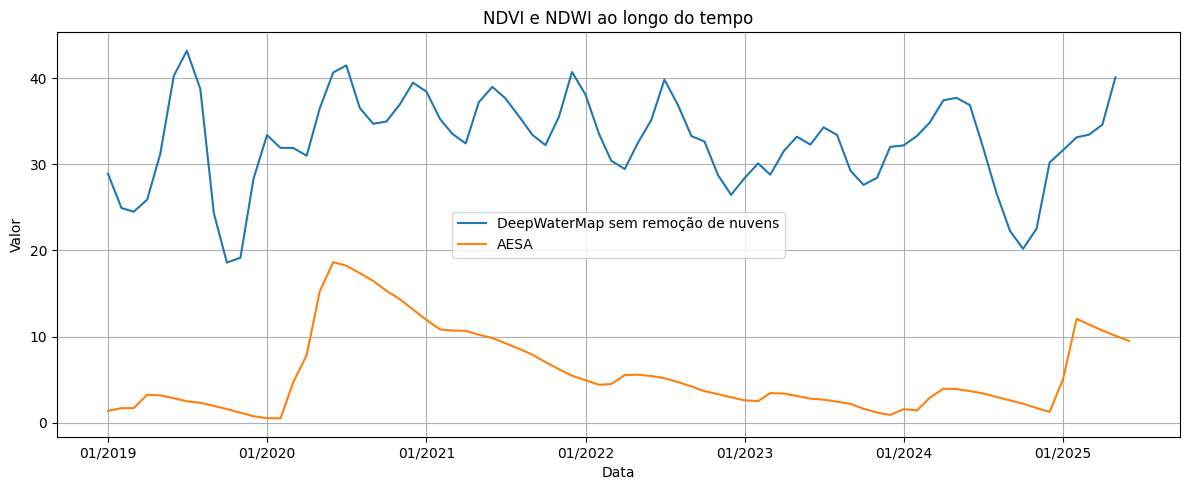

In [1085]:
deepwater_mean_df = media_mensal_por_ano(deepwater_map_df)

deepwater_mean_df["volume_m2"] = savgol_filter(
    deepwater_mean_df["volume_m2"], window_length=10, polyorder=4
)

plot_series_ano_mes(
    {
        "DeepWaterMap sem remoção de nuvens": deepwater_mean_df,
        "AESA": aesa_mean_df
    },
    data_inicio="01/2019",
    data_fim="06/2025",
    titulo="NDVI e NDWI ao longo do tempo"
)


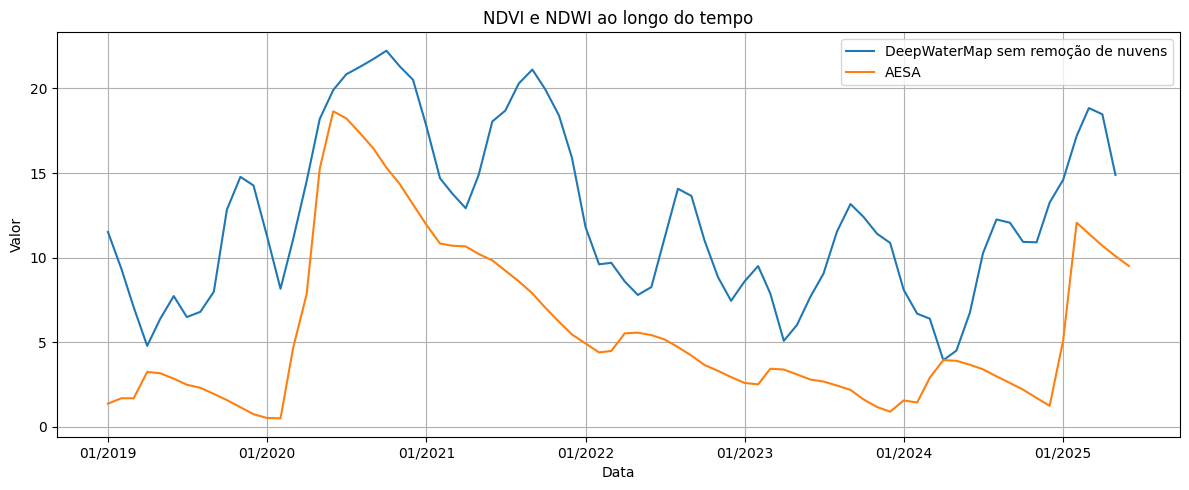

In [1086]:
deepwater_mean_df = media_mensal_por_ano(deepwater_map_df.drop(columns=['volume_m2']).rename(columns={'fmask_volume_m2': 'volume_m2'}))

deepwater_mean_df["volume_m2"] = savgol_filter(
    deepwater_mean_df["volume_m2"], window_length=10, polyorder=4
)

plot_series_ano_mes(
    {
        "DeepWaterMap sem remoção de nuvens": deepwater_mean_df,
        "AESA": aesa_mean_df
    },
    data_inicio="01/2019",
    data_fim="06/2025",
    titulo="NDVI e NDWI ao longo do tempo"
)


### Median filter

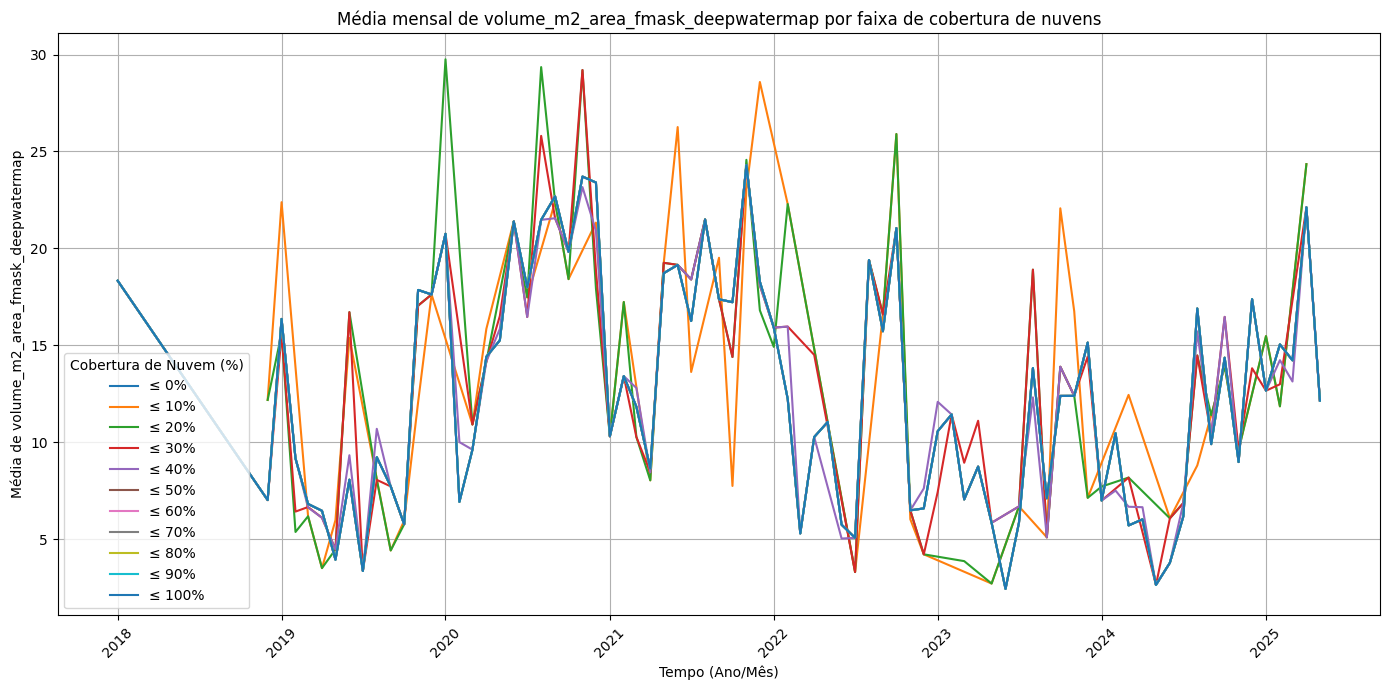

In [1087]:
from scipy.ndimage import median_filter

df_resultado["volume_m2_area_fmask_deepwatermap_median"] = median_filter(
    df_resultado["volume_m2_area_fmask_deepwatermap"], size=30
)
plot_water_x_cloud_percent_over_time(
    df_resultado.loc[df_resultado["CLOUDY_PIXEL_PERCENTAGE"] <= 50],
    y_variable="volume_m2_area_fmask_deepwatermap",
)


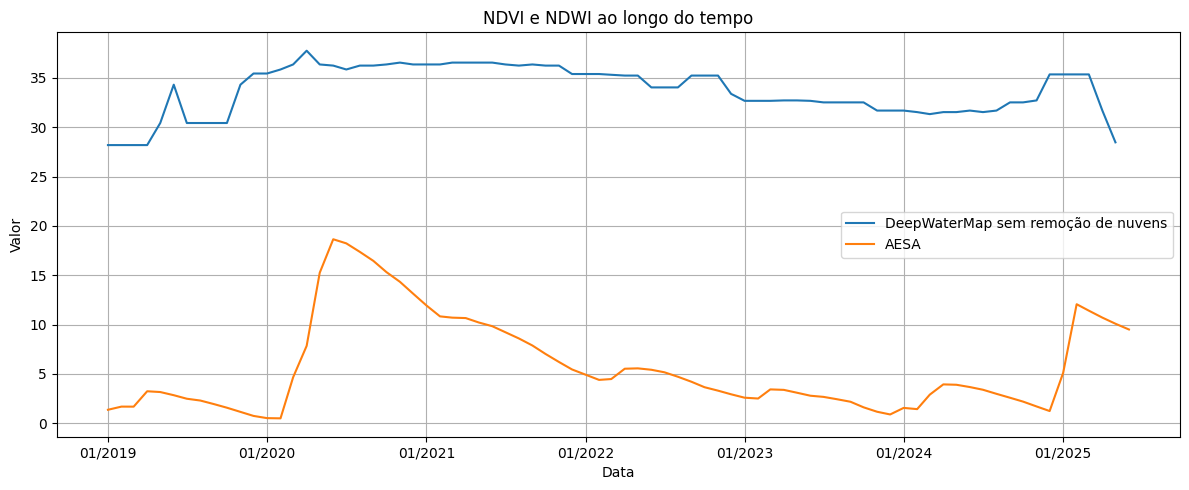

In [1088]:
deepwater_mean_df = media_mensal_por_ano(deepwater_map_df)

deepwater_mean_df["volume_m2"] = median_filter(
    deepwater_mean_df["volume_m2"], size=20
)

plot_series_ano_mes(
    {
        "DeepWaterMap sem remoção de nuvens": deepwater_mean_df,
        "AESA": aesa_mean_df
    },
    data_inicio="01/2019",
    data_fim="06/2025",
    titulo="NDVI e NDWI ao longo do tempo"
)


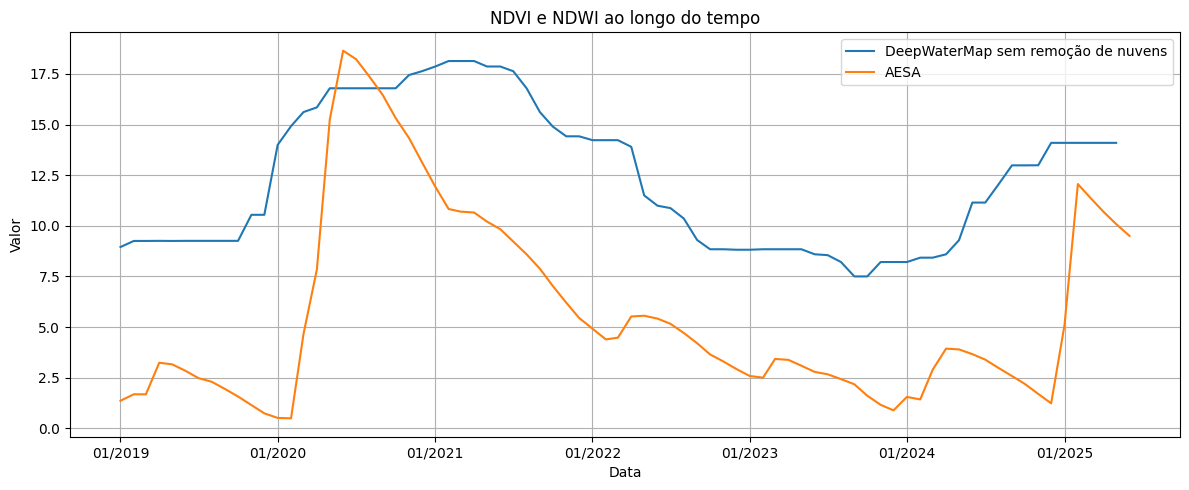

In [1089]:
deepwater_mean_df = media_mensal_por_ano(deepwater_map_df.drop(columns=['volume_m2']).rename(columns={'fmask_volume_m2': 'volume_m2'}))

deepwater_mean_df["volume_m2"] = median_filter(
    deepwater_mean_df["volume_m2"], size=20
)

plot_series_ano_mes(
    {
        "DeepWaterMap sem remoção de nuvens": deepwater_mean_df,
        "AESA": aesa_mean_df
    },
    data_inicio="01/2019",
    data_fim="06/2025",
    titulo="NDVI e NDWI ao longo do tempo"
)


### Z-Score + SavGol

C:\Users\weverton.vitor\AppData\Local\Temp\ipykernel_38272\3811494513.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultado["z"] = zscore(df_resultado["volume_m2_area_fmask_deepwatermap"])


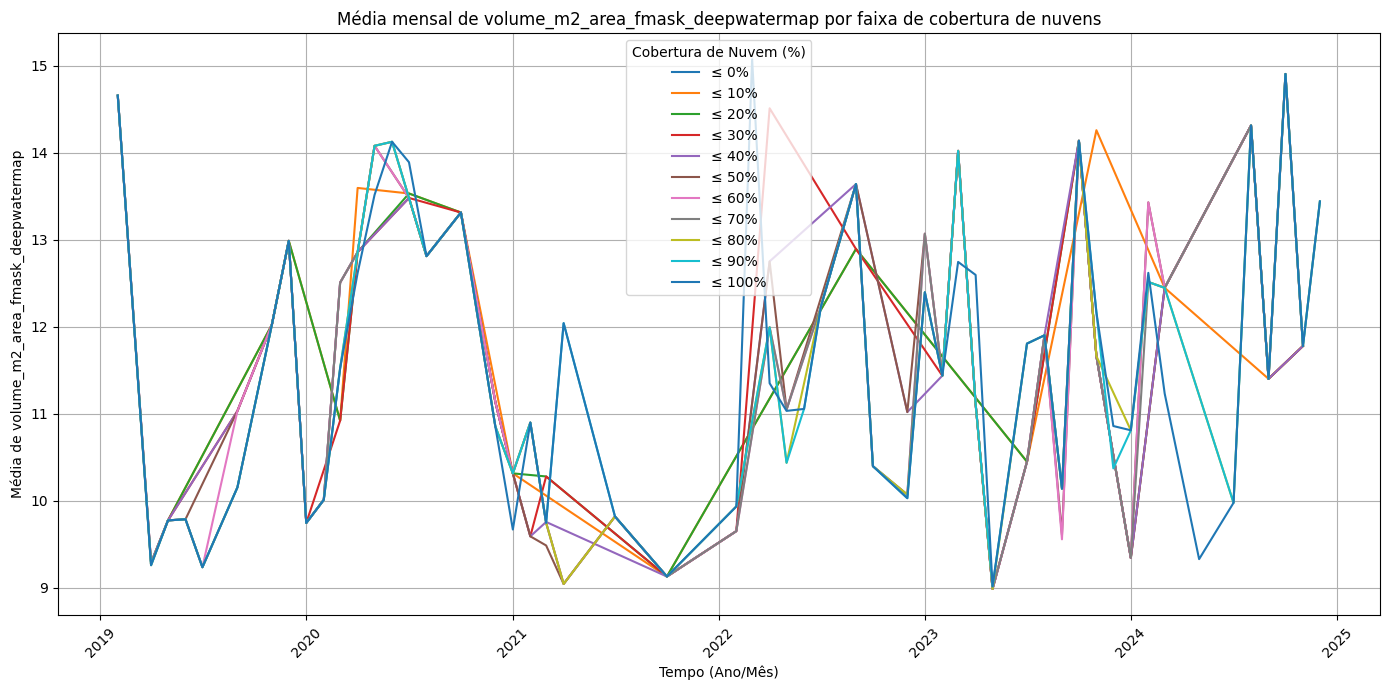

In [1090]:
from scipy.stats import zscore

# Remove temporariamente os NaNs
df_resultado = df_resultado.dropna()

df_resultado["z"] = zscore(df_resultado["volume_m2_area_fmask_deepwatermap"])
df_resultado_filtrado = df_resultado[df_resultado["z"].abs() < 0.4]  # remove outliers com z > 2

plot_water_x_cloud_percent_over_time(
    df_resultado_filtrado.loc[df_resultado["CLOUDY_PIXEL_PERCENTAGE"] <= 100],
    y_variable="volume_m2_area_fmask_deepwatermap",
)

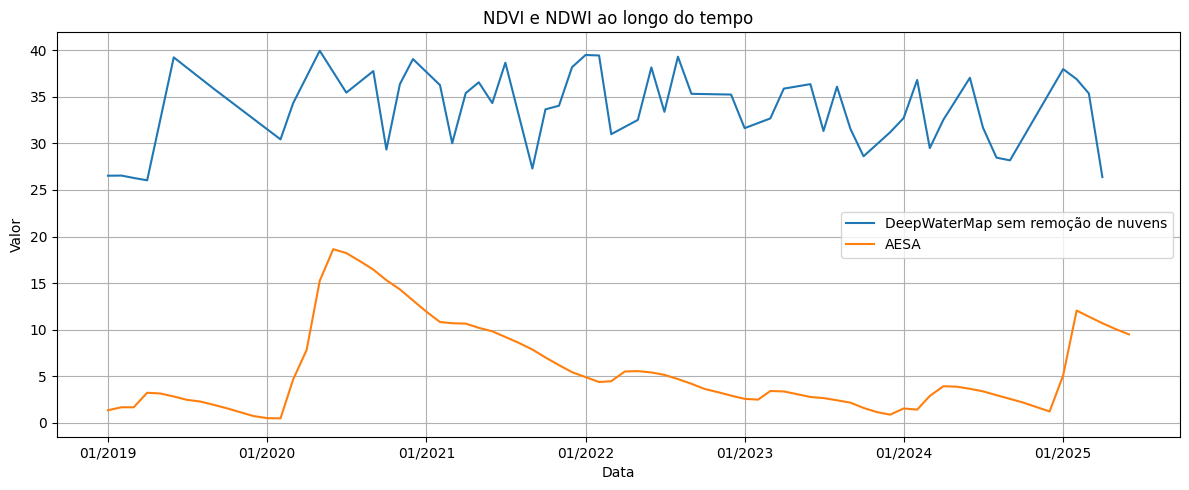

In [1091]:
deepwater_mean_df = media_mensal_por_ano(deepwater_map_df)

deepwater_mean_df = deepwater_mean_df.dropna()

deepwater_mean_df["z"] = zscore(deepwater_mean_df["volume_m2"])
deepwater_mean_df = deepwater_mean_df[deepwater_mean_df["z"].abs() < 1]  # remove outliers com z > 2

plot_series_ano_mes(
    {
        "DeepWaterMap sem remoção de nuvens": deepwater_mean_df,
        "AESA": aesa_mean_df
    },
    data_inicio="01/2019",
    data_fim="06/2025",
    titulo="NDVI e NDWI ao longo do tempo"
)


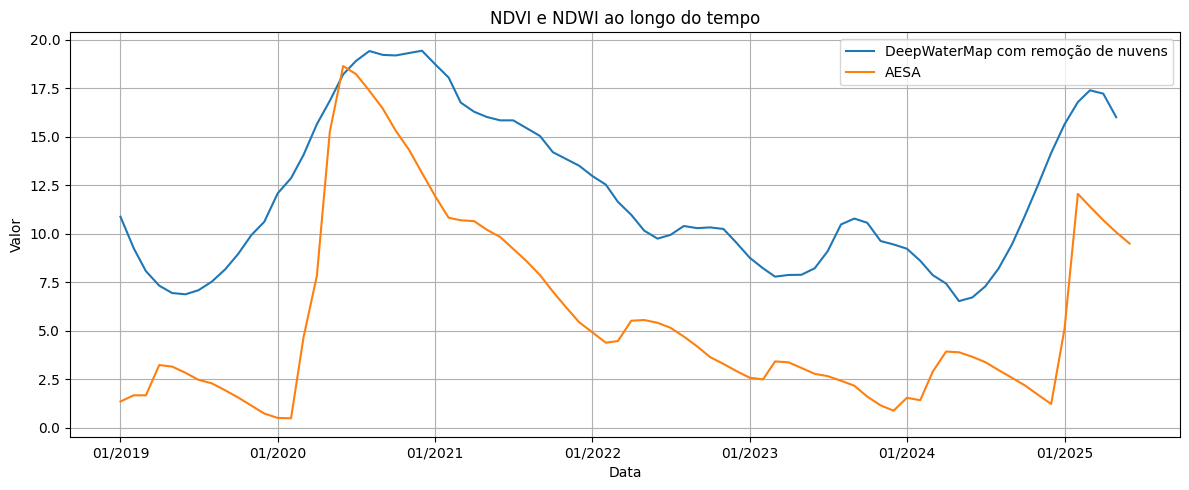

In [1092]:
deepwater_mean_df = media_mensal_por_ano(deepwater_map_df.drop(columns=['volume_m2']).rename(columns={'fmask_volume_m2': 'volume_m2'}))

deepwater_mean_df = deepwater_mean_df.dropna()

deepwater_mean_df["z"] = zscore(deepwater_mean_df["volume_m2"])
deepwater_mean_df = deepwater_mean_df[deepwater_mean_df["z"].abs() < 2]  # remove outliers com z > 2

deepwater_mean_df["volume_m2"] = savgol_filter(
    deepwater_mean_df["volume_m2"], window_length=25, polyorder=4
)



plot_series_ano_mes(
    {
        "DeepWaterMap com remoção de nuvens": deepwater_mean_df,
        "AESA": aesa_mean_df
    },
    data_inicio="01/2019",
    data_fim="06/2025",
    titulo="NDVI e NDWI ao longo do tempo"
)
